## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13886857918917759060
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
}
incarnation: 11802426358241059869
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [2]:

import sys
sys.path.insert(0, "/home/ubuntu")

import os.path as osp

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [4]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'
# class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()
class_name = 'chair'

Load Point-Clouds

In [5]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

6778 pclouds were loaded. They belong in 1 shape-classes.


Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [6]:
train_params = default_train_params()

In [7]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [8]:
conf = Conf(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

If you ran the above lines, you can reload a saved model like this:

In [9]:
load_pre_trained_ae = True
restore_epoch = 500
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("single_class_ae_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("single_class_ae_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024 Tensor("single_class_ae_2/Relu_5:0", shape=(?, 256), dtype=float32)
output size: 256 

Build AE Model.

In [10]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("single_class_ae_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("single_class_ae_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024 Tensor("single_class_ae_2/Relu_5:0", shape=(?, 256), dtype=float32)
output size: 256 

Train the AE (save output to train_stats.txt) 

In [ ]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.4770', 'loss=', '0.003901071')
INFO:tensorflow:../data/single_class_ae/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '0.3772', 'loss=', '0.001697187')
('Epoch:', '0003', 'training time (minutes)=', '0.3773', 'loss=', '0.001463005')
('Epoch:', '0004', 'training time (minutes)=', '0.3772', 'loss=', '0.001332250')
('Epoch:', '0005', 'training time (minutes)=', '0.3774', 'loss=', '0.001282774')
('Epoch:', '0006', 'training time (minutes)=', '0.3772', 'loss=', '0.001199542')
('Epoch:', '0007', 'training time (minutes)=', '0.3774', 'loss=', '0.001159124')
('Epoch:', '0008', 'training time (minutes)=', '0.3778', 'loss=', '0.001080624')
('Epoch:', '0009', 'training time (minutes)=', '0.3778', 'loss=', '0.001070552')
('Epoch:', '0010', 'training time (minutes)=', '0.3779', 'loss=', '0.001048956')
INFO:tensorflow:../data/single_class_ae/models.ckpt-10 is not in all_model_che

('Epoch:', '0090', 'training time (minutes)=', '0.3781', 'loss=', '0.000626051')
INFO:tensorflow:../data/single_class_ae/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0091', 'training time (minutes)=', '0.3779', 'loss=', '0.000613323')
('Epoch:', '0092', 'training time (minutes)=', '0.3785', 'loss=', '0.000630501')
('Epoch:', '0093', 'training time (minutes)=', '0.3780', 'loss=', '0.000642970')
('Epoch:', '0094', 'training time (minutes)=', '0.3781', 'loss=', '0.000614589')
('Epoch:', '0095', 'training time (minutes)=', '0.3785', 'loss=', '0.000607697')
('Epoch:', '0096', 'training time (minutes)=', '0.3785', 'loss=', '0.000613146')
('Epoch:', '0097', 'training time (minutes)=', '0.3787', 'loss=', '0.000613789')
('Epoch:', '0098', 'training time (minutes)=', '0.3782', 'loss=', '0.000617140')
('Epoch:', '0099', 'training time (minutes)=', '0.3783', 'loss=', '0.000615555')
('Epoch:', '0100', 'training time (minutes)=', '0.3784', 'loss=', '0.00061815

('Epoch:', '0179', 'training time (minutes)=', '0.3785', 'loss=', '0.000546836')
('Epoch:', '0180', 'training time (minutes)=', '0.3782', 'loss=', '0.000549338')
INFO:tensorflow:../data/single_class_ae/models.ckpt-180 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0181', 'training time (minutes)=', '0.3782', 'loss=', '0.000548392')
('Epoch:', '0182', 'training time (minutes)=', '0.3782', 'loss=', '0.000549366')
('Epoch:', '0183', 'training time (minutes)=', '0.3778', 'loss=', '0.000538170')
('Epoch:', '0184', 'training time (minutes)=', '0.3781', 'loss=', '0.000537569')
('Epoch:', '0185', 'training time (minutes)=', '0.3783', 'loss=', '0.000535448')
('Epoch:', '0186', 'training time (minutes)=', '0.3782', 'loss=', '0.000535256')
('Epoch:', '0187', 'training time (minutes)=', '0.3779', 'loss=', '0.000534555')
('Epoch:', '0188', 'training time (minutes)=', '0.3781', 'loss=', '0.000542096')
('Epoch:', '0189', 'training time (minutes)=', '0.3783', 'loss=', '0.0005408

('Epoch:', '0268', 'training time (minutes)=', '0.3784', 'loss=', '0.000511798')
('Epoch:', '0269', 'training time (minutes)=', '0.3779', 'loss=', '0.000509687')
('Epoch:', '0270', 'training time (minutes)=', '0.3780', 'loss=', '0.000506617')
INFO:tensorflow:../data/single_class_ae/models.ckpt-270 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0271', 'training time (minutes)=', '0.3781', 'loss=', '0.000510180')
('Epoch:', '0272', 'training time (minutes)=', '0.3782', 'loss=', '0.000513819')
('Epoch:', '0273', 'training time (minutes)=', '0.3783', 'loss=', '0.000506885')
('Epoch:', '0274', 'training time (minutes)=', '0.3781', 'loss=', '0.000512343')
('Epoch:', '0275', 'training time (minutes)=', '0.3782', 'loss=', '0.000505070')
('Epoch:', '0276', 'training time (minutes)=', '0.3781', 'loss=', '0.000505088')
('Epoch:', '0277', 'training time (minutes)=', '0.3780', 'loss=', '0.000506119')
('Epoch:', '0278', 'training time (minutes)=', '0.3783', 'loss=', '0.0005078

('Epoch:', '0357', 'training time (minutes)=', '0.3782', 'loss=', '0.000492237')
('Epoch:', '0358', 'training time (minutes)=', '0.3783', 'loss=', '0.000490143')
('Epoch:', '0359', 'training time (minutes)=', '0.3781', 'loss=', '0.000492669')
('Epoch:', '0360', 'training time (minutes)=', '0.3782', 'loss=', '0.000484779')
INFO:tensorflow:../data/single_class_ae/models.ckpt-360 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0361', 'training time (minutes)=', '0.3782', 'loss=', '0.000489106')
('Epoch:', '0362', 'training time (minutes)=', '0.3787', 'loss=', '0.000482154')
('Epoch:', '0363', 'training time (minutes)=', '0.3781', 'loss=', '0.000484327')
('Epoch:', '0364', 'training time (minutes)=', '0.3785', 'loss=', '0.000491455')
('Epoch:', '0365', 'training time (minutes)=', '0.3780', 'loss=', '0.000490849')
('Epoch:', '0366', 'training time (minutes)=', '0.3781', 'loss=', '0.000483604')
('Epoch:', '0367', 'training time (minutes)=', '0.3782', 'loss=', '0.0004845

Get a batch of reconstuctions and their latent-codes.

In [10]:
feed_pc, feed_model_names, _ = all_pc_data.next_batch(10)
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

Use any plotting mechanism such as matplotlib to visualize the results.

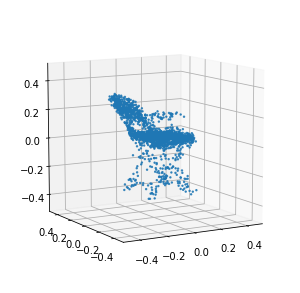

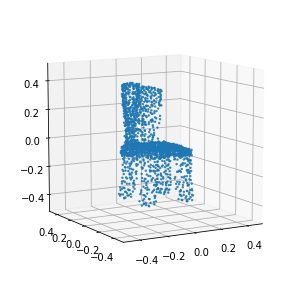

In [14]:
i = 2
plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);

i = 3
plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);